In [1]:
from agents import ModelAverager, DeltaHedge, DRLAgent
from discrete_environments import DiscreteEnv
from data_generators import GBM_Generator
import utils
import numpy as np

In [2]:
S0 = 100

# Annualized
sigma = 0.01*np.sqrt(250) # 1% vol per day
r = 0.0

freq = 0.2 # corresponds to trading freq of 5x per day
ttm = 50
kappa = 0.4
cost_multiplier = 0.0
gamma = 0.99

generator = GBM_Generator(S0, r, sigma, freq)

env_args = {
    "generator" : generator,
    "ttm" : ttm,
    "kappa" : kappa,
    "cost_multiplier" : cost_multiplier,
    "testing" : False
}

n_steps = 5000
n_batches = 5

eps_func = utils.EpsFunction(n_steps).get_func()

In [3]:
env = DiscreteEnv(**env_args)
drl_env, _ = env.get_sb_env()
agent = ModelAverager(env, gamma)


C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [4]:
total_timesteps = 1000000
n_eval_episodes = 100

DQN_PARAMS = {
    "buffer_size": 750000,
    "learning_rate": 0.0001, # utils.custom_schedule(0.0001, 0.0004, 0.00001, 0.75),
    "learning_starts": 50000,
    "exploration_fraction": 1.0,
    "exploration_final_eps": 0.05,
    "gamma": 0.9,
    "target_update_interval" : 30000,
    "train_freq": 50,
    "tau": 0.8,
    "batch_size": 128,
    "max_grad_norm": 1.0
}

model_kwargs = DQN_PARAMS

policy_kwargs = {
    "net_arch": [10,10,10,10,10]
}

drl_agent = DRLAgent(drl_env)
model = drl_agent.get_model('dqn', verbose=1, model_kwargs=model_kwargs, policy_kwargs=policy_kwargs)

trained_model = drl_agent.train_model(model=model, 
                                tb_log_name='dqn',
                                total_timesteps=total_timesteps,
                                n_eval_episodes=n_eval_episodes)


{'buffer_size': 750000, 'learning_rate': 3e-05, 'learning_starts': 50000, 'exploration_fraction': 0.9, 'exploration_final_eps': 0.05, 'gamma': 0.99, 'target_update_interval': 10000, 'train_freq': 4000, 'tau': 0.7, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/dqn\dqn_15
----------------------------------
| rollout/            |          |
|    exploration rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2245     |
|    time_elapsed     | 0        |
|    total timesteps  | 200      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2409     |
|    time_elapsed     | 0        |
|    total timesteps  | 400      |
----------------------------------
----------------------------------
| rollout/            |          |
|    explora

In [5]:
# Careful here: testing=true affects following training
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq=freq, seed = 1334)
env_args["generator"] = generator
env_args["testing"] = True

test_env = DiscreteEnv(**env_args)

# Trained Net prediction
df = DRLAgent.Prediction(
    model=trained_model, 
    environment = test_env,
    pred_args = {"deterministic":True})

df = df['output']

hit end!


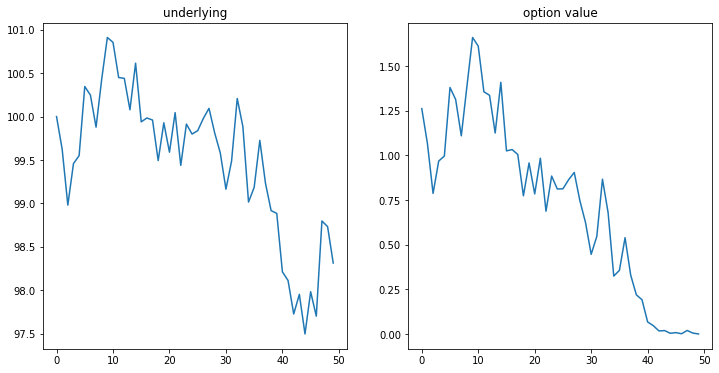

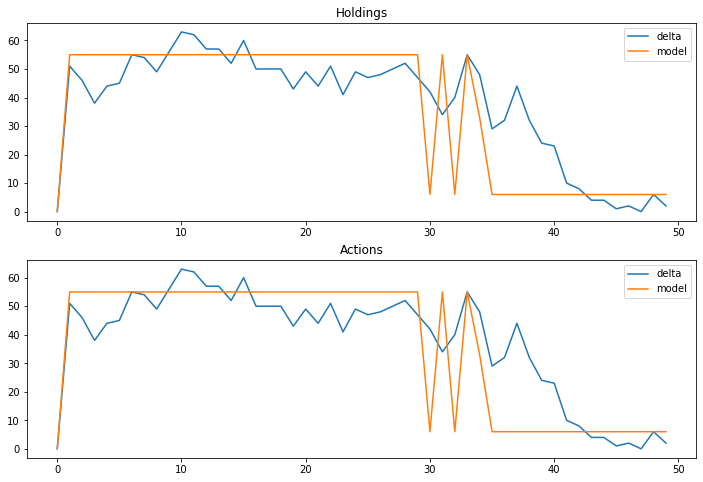

In [6]:
test_env_delta = DiscreteEnv(**env_args)
delta_agent = DeltaHedge(r, sigma, S0)
delta = delta_agent.test(test_env_delta)

utils.plot_decisions(delta, df)

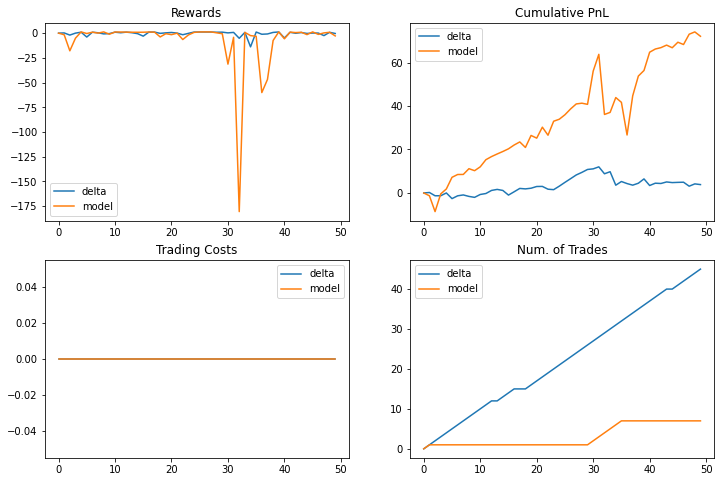

In [7]:
utils.plot_pnl(delta, df)

C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


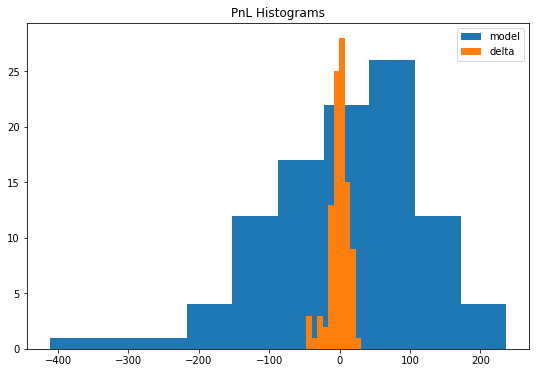

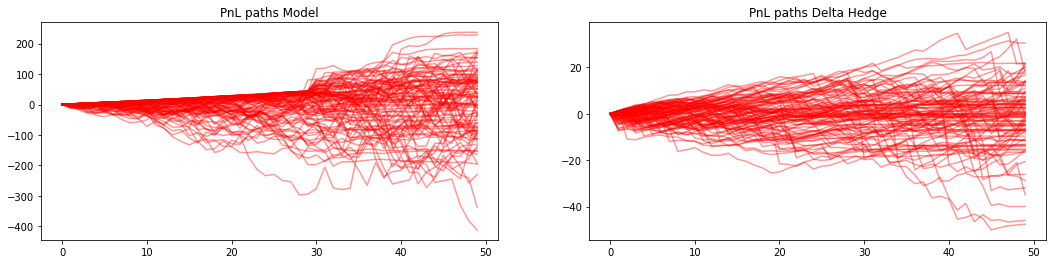

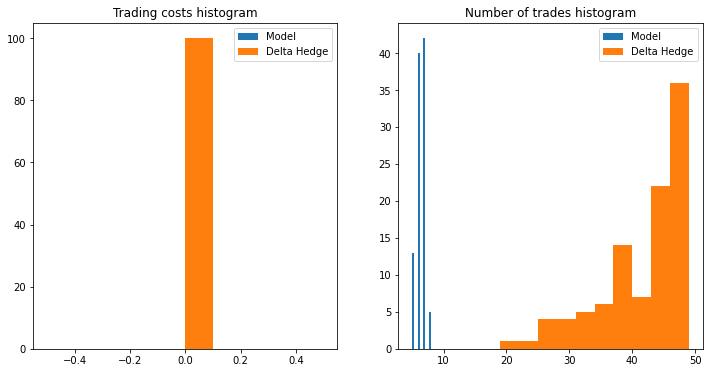

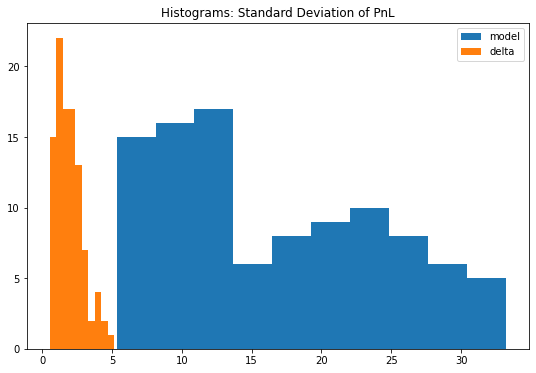

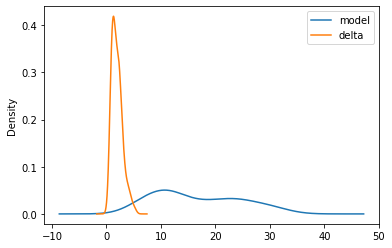

In [8]:
isDRL = True
n_sim = 100
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq = freq)
env_args["generator"] = generator
env_args["testing"] = True
pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl(trained_model, delta_agent, n_sim, isDRL, env_args)
utils.plot_pnl_hist(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)

## Regression Tree training

In [9]:
# graph = agent.train(n_steps, n_batches, eps_func)
# graph
agent.train(n_steps, n_batches, eps_func)

100%|██████████| 5000/5000 [00:03<00:00, 1332.45it/s]


C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


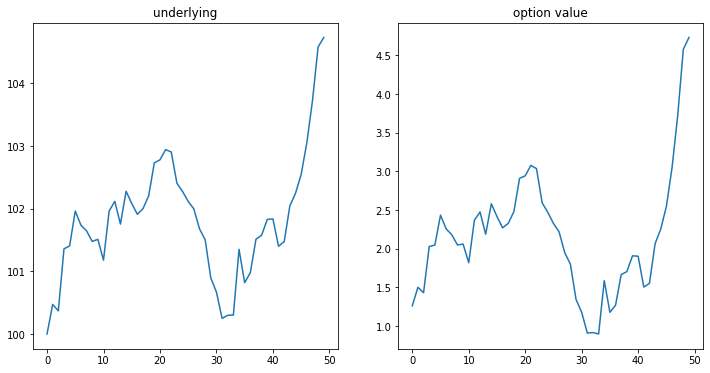

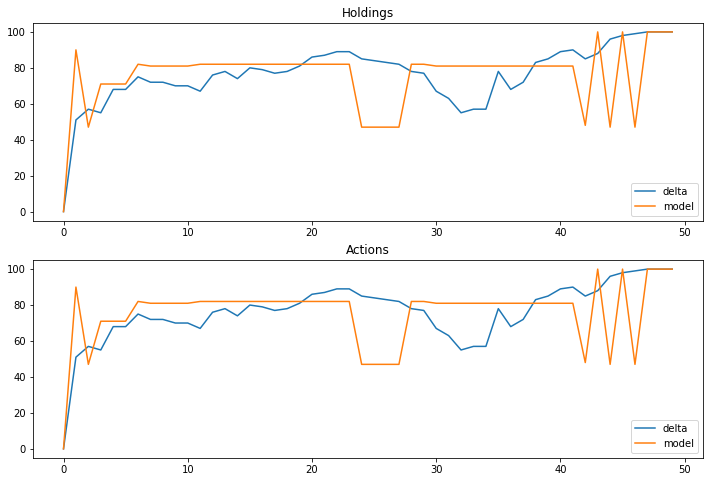

In [10]:
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq=freq, seed = 1234)
env_args["generator"] = generator
env_args["testing"] = True

test_env = DiscreteEnv(**env_args)
test_env_delta = DiscreteEnv(**env_args)

df = agent.test(test_env)

delta_agent = DeltaHedge(r, sigma, S0)
delta = delta_agent.test(test_env_delta)

utils.plot_decisions(delta, df)

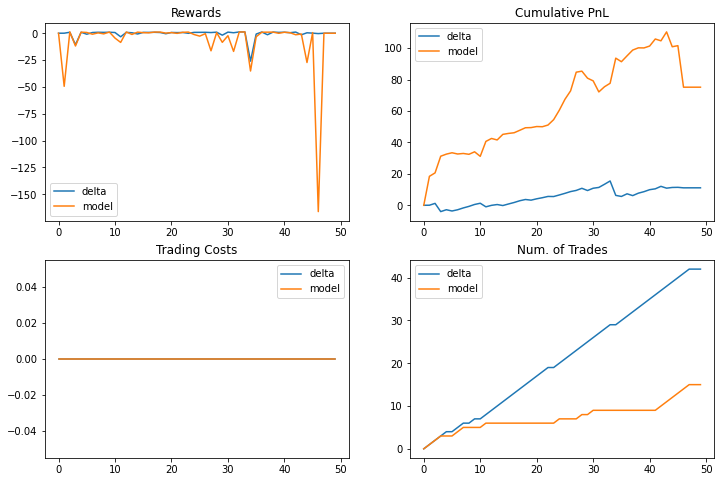

In [11]:
utils.plot_pnl(delta, df)

In [12]:
n_sim = 100
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq = freq)
env_args["generator"] = generator
env_args["testing"] = True
pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl(agent, delta_agent, n_sim, env_args)
utils.plot_pnl_hist(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)

TypeError: simulate_pnl() missing 1 required positional argument: 'env_kwargs'